# Horizon tutorial

This notebook shows how we work with surfaces inside the seismic volume of amplitudes. These surfaces are called horizons, and they are boundaries between different types of rocks. Here you can find how effectively operate with them to get insights about a field.

Before proceeding, make sure to check out our [previous tutorials on Seismic Geometry](./01_Geometry_part_1.ipynb).

Contents:

* [Horizon initialization](#initialization)
* [Horizon representations](#representations)
* [Geological attributes and simple data manipulations](#attributes)
* [Caching](#cache)
* [Horizon merge](#merge)
* [Additional manipulations](#add_manipulations)

In [1]:
# All the necessary imports
import sys
import warnings
import numpy as np

warnings.filterwarnings('ignore')

sys.path.append('..')
from seismiqb import Field, Horizon, plot_image

# Constants
FIGSIZE = (12, 7)

<a id='initialization'></a>
# Horizon initialization

Every task starts with a horizon initialization. To create an instance of `Horizon`, we must provide a **data container** and a reference to a **field**.

We can create a `Horizon` instance from various containers:

- path to a csv-like file. We support CHARISMA and GENERAL PURPOSE geological formats
- array of shape (N, 3), where each row is a point in *(iline, crossline, depth)* format
- matrix of shape *(n_ilines, n_crosslines)* and left-upper point in the cube coordinate system
- matrix of the same shape as the cube spatial range
- mapping (dictionary) from *(iline, crossline)* pairs to *depth*

So, let's load a horizon:


Horizon etp_BP10_anon for 001_YETYPUR loaded from file
Ilines range:      0 to 2559
Xlines range:      1 to 1403
Depth range:       908 to 1076
Depth mean:        983.258
Depth std:         42.3661

Length:            2902207
Perimeter:         8646
Coverage:          1.1915
Solidity:          1.0
Num of holes:      0



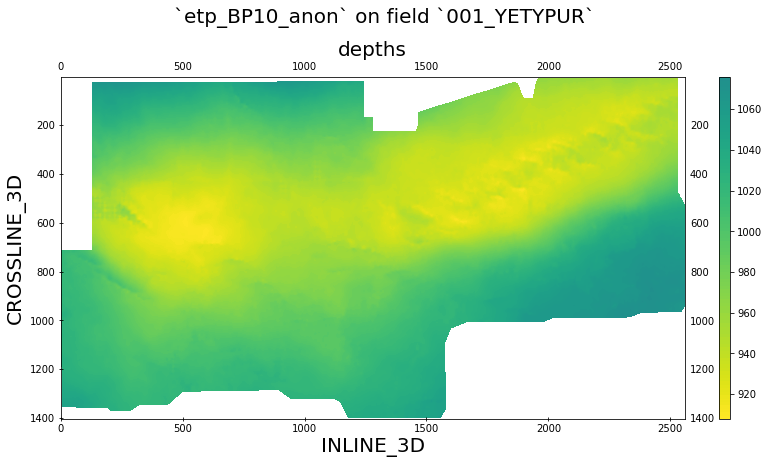

CPU times: user 4.6 s, sys: 1.32 s, total: 5.91 s
Wall time: 5.57 s


In [2]:
%%time
field = Field(geometry='/data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.sgy')

horizon = Horizon(
    storage='~/INPUTS/HORIZONS/FINAL/etp_BP10_anon',
    field=field
)

print(horizon)
horizon.show(figsize=FIGSIZE)

Horizon was fastly loaded from the storage, and we extracted general information about it. Coverage is more than 1.0, which means that the horizon does not match the geology: probably, that is an artifact of the auto-picking procedure.

The `filter` method helps clean a horizon from extra traces.


Horizon etp_BP10_anon for 001_YETYPUR loaded from file
Ilines range:      0 to 2559
Xlines range:      1 to 1403
Depth range:       908 to 1076
Depth mean:        980.459
Depth std:         43.4773

Length:            2424324
Perimeter:         8242
Coverage:          0.99528
Solidity:          1.0
Num of holes:      0



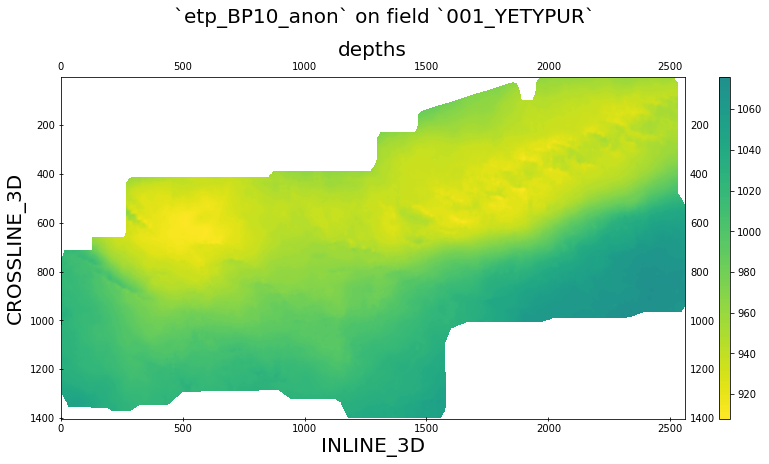

CPU times: user 1.81 s, sys: 365 ms, total: 2.17 s
Wall time: 1.78 s


In [3]:
%%time
horizon.filter()

print(horizon)
horizon.show(figsize=FIGSIZE)

The `show` method allows us to check the depth map of a horizon from above. Additionally, the `SeismiQB` library has the `show_slide` method, which can visualize the horizon concerning the seismic data.

CPU times: user 119 ms, sys: 21.5 ms, total: 141 ms
Wall time: 139 ms


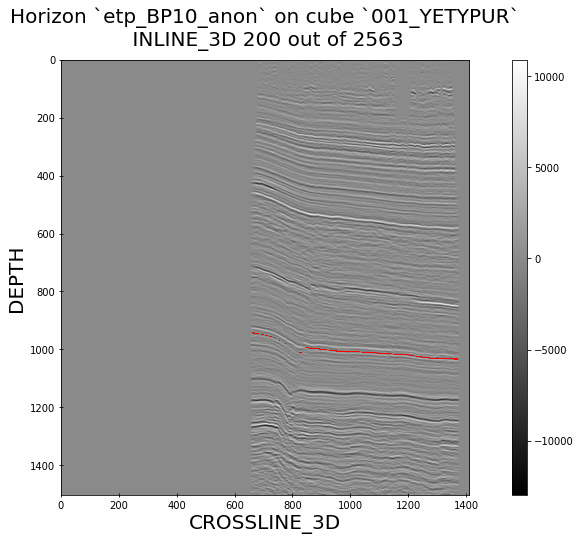

In [4]:
%%time
horizon.show_slide(200, width=10, y=0.92, separate=False,
                   cmap=['gray', 'red'], grid=False, figsize=(18, 8))

<a id='representations'></a>
# Horizon representations

Before talking about manipulations with horizons, we must pay attention to horizon representations in `SeismiQB`.

The main thing that you need to know is that `Horizon` instances have two main underlying storages: `points` and `matrix`.

- `points` is an array of shape *(N, 3)*, where each row is a point in *(iline, crossline, depth)* format;
- `matrix` is an array of shape *(n_ilines, n_crosslines)*. Essentially, that is a depth map of a horizon.

In [5]:
horizon_points = horizon.points
print("Points representation:\n")
print(horizon.points[:5], '\n')
print("Shape: ", horizon.points.shape)
print("Stored elements:", horizon_points.size)
print(f"Memory: {horizon_points.nbytes/(1024**3):4.2f} GB\n\n")

print("Matrix representation:")
horizon_matrix = horizon.matrix
print("Shape: ", horizon.matrix.shape)
print("Stored elements:", horizon_matrix.size)
print(f"Memory: {horizon_matrix.nbytes/(1024**3):4.2f} GB")

Points representation:

[[   0  737 1020]
 [   0  738 1020]
 [   0  739 1020]
 [   0  740 1020]
 [   0  741 1020]] 

Shape:  (2424324, 3)
Stored elements: 7272972
Memory: 0.03 GB


Matrix representation:
Shape:  (2560, 1403)
Stored elements: 3591680
Memory: 0.01 GB


**The reason to use multiple storages** is simple: speed and efficiency. Some of the operations can be done faster using the `points` array, while others work better with `matrix`.


**Note** that pretty much attributes of `Horizon` instances are **loaded lazily**. If the horizon is initialized from `points`, then the `matrix` attribute is created at the first access.

That is important when we generate thousands of horizons and merge them in seismic interpretation tasks. The same goes for statistics and geological properties, which we will show next.

<a id='attributes'></a>
# Geological attributes and simple data manipulations

For getting insights into geological surfaces, we need to manipulate various attributes.

By default, the `show` method displays the depth map of a horizon surface. We can show other geological attributes by setting the `src` positional argument:

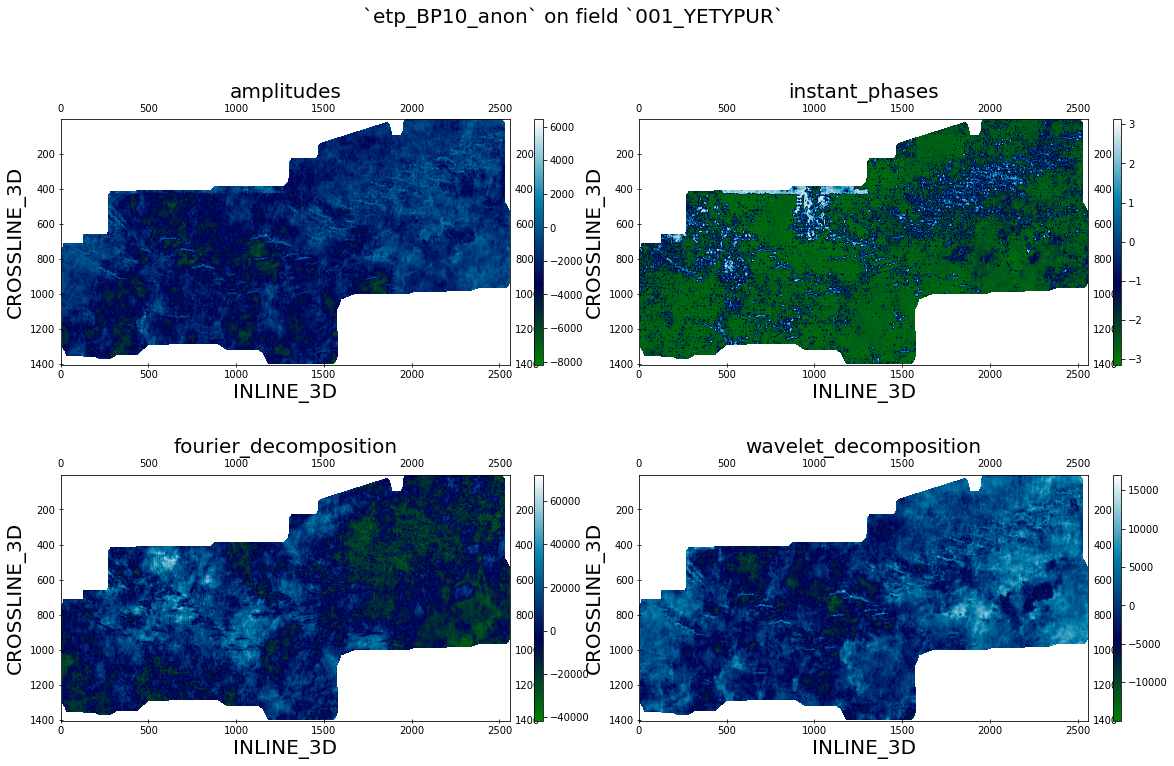

CPU times: user 5min 3s, sys: 1min 53s, total: 6min 56s
Wall time: 4min 32s


In [6]:
%%time
horizon.show(['amplitudes', 'instant_phases', 'fourier_decomposition', 'wavelet_decomposition'],
             separate=True, nrows=2, ncols=2, figsize=(19, 12))

Those simple geological attributes allow us to get a lot of insight into the horizon. To get even more, we can use the `evaluate` method, which computes a detailed description of the labeled surface:

- its **spatial characteristics** like number of points, number of holes, and perimeter
- how many of the cube **non-zero traces** are labeled
- how many of the **horizon-interior traces** are labeled
- **coherence map** along the horizon surface. There is a wealth of various horizon-assessment maps that is demonstrated in [this tutorial](./04_Metrics.ipynb)


Number of labeled points:                         2424324
Number of points inside borders:                  2424324
Perimeter (length of borders):                    8242
Percentage of labeled non-bad traces:             0.995280439441338
Percentage of labeled traces inside borders:      1.0
Number of holes inside borders:                   0

CPU times: user 1min 13s, sys: 1.35 s, total: 1min 14s
Wall time: 1min 14s


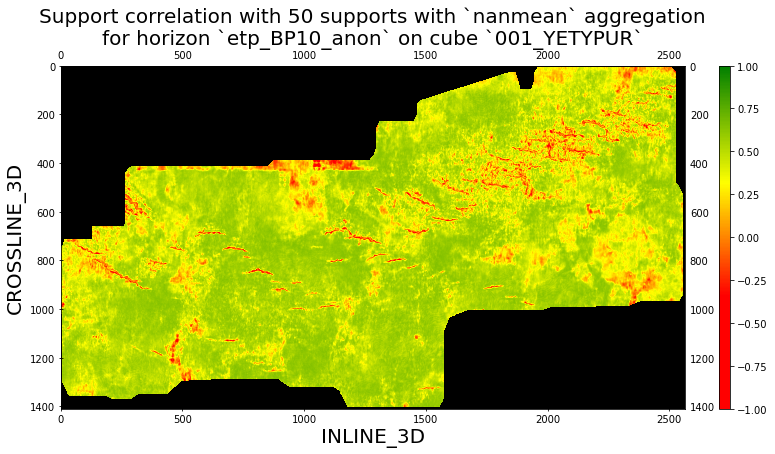

In [7]:
%%time
_ = horizon.evaluate(figsize=FIGSIZE, bad_color='black')

The other capabilities of the `Horizon` class are cutting the data along with horizon instance from the cube of amplitudes. It can either cut one slice along a specified axis or the entire seismic volume in a specified window:

Shape of cut subcube: (2563, 1409, 777)
Size of the array: 10.45 GB

Shape of cut subcube: (2563, 777)
Size of the array: 0.01 GB

CPU times: user 7min 31s, sys: 12.1 s, total: 7min 43s
Wall time: 7min 43s


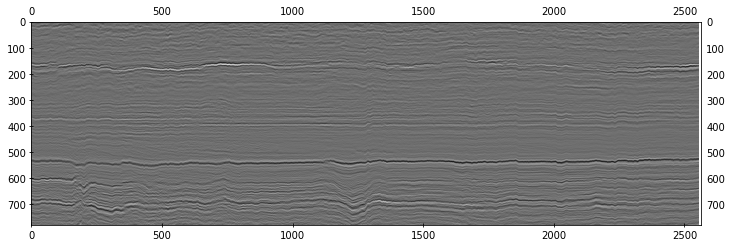

In [8]:
%%time
cut_volume = horizon.get_cube_values(window=777)

print(f'Shape of cut subcube: {cut_volume.shape}')
print(f'Size of the array: {cut_volume.nbytes/(1024**3):4.2f} GB\n')

cut_line = cut_volume[:, 777, :]

print(f'Shape of cut subcube: {cut_line.shape}')
print(f'Size of the array: {cut_line.nbytes/(1024**3):4.2f} GB\n')

plot_image(np.squeeze(cut_line), cmap='gray')

<a id='cache'></a>
# Caching

For the effective work with horizons attributes, we cache the information calculated during the work. This helps to save time on repeated actions.

Cache API is the same as in the case of `SeismicGeometry`:

In [9]:
# Cache inspectation:
print(f"Cached memory: {horizon.cache_size:4.2f} GB")

# Cache nullification:
horizon.reset_cache()

print(f"Cached memory after reset: {horizon.cache_size:4.2f} GB")

Cached memory: 0.74 GB
Cached memory after reset: 0.00 GB


This is all about base data insights. Moreover, `SeismiQB` has functionality for manipulating horizons that helps solve seismic interpretation tasks.

<a id='merge'></a>
# Horizon merge

Seismic cubes are enormous in disk space, which makes work with them more complicated: we split seismic data into parts, manipulate them, and extract useful information about a field.
In the horizon detection task, we predict horizon location on each data slice and sew horizon parts into one.
For efficient horizon merging, we implement a set of practical methods:

- `check_proximity` and `verify_merge` assess if the horizons are mergeable by making conclusions about spatial and depth horizons relations.
 
Pair of horizons is deemed either:
 - `overlapping` if they have a spatial overlap and meet the threshold of heights-distance. We definitely can merge such horizons.
 - `adjacent` if they don't have an overlap but are within a margin spatial-wise. More in-depth analysis is required to decide whether we can merge such horizons or not.
 - `distant` and `separated` if the horizons are too far away from each other spatial-wise or depth-wise. We should not merge such horizons.
 
If we have two mergeable horizons and we know their mutual location, then we can use one of the options:
 
- `overlap_merge` takes two overlapping horizons and creates a new one. In the overlapping area, we take the mean value of horizon parts depth.

- `adjacent_merge` takes two non-overlapping but spatially close horizons, checks the height difference at the nearest edges of horizons, and merges them into one.

Let's try merge methods with a simple example:

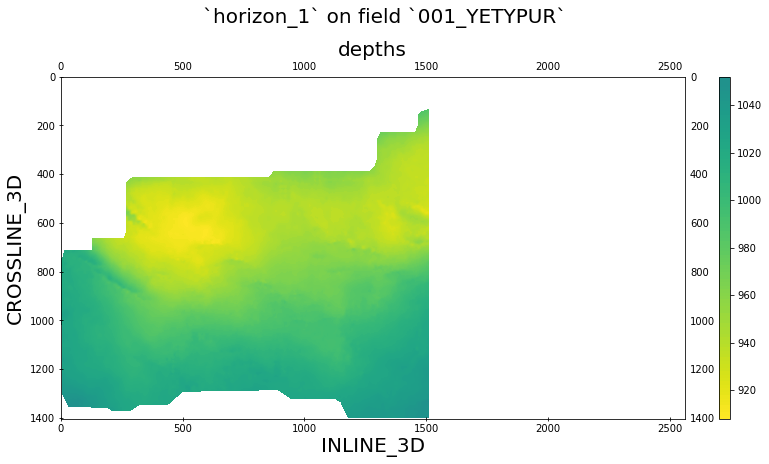

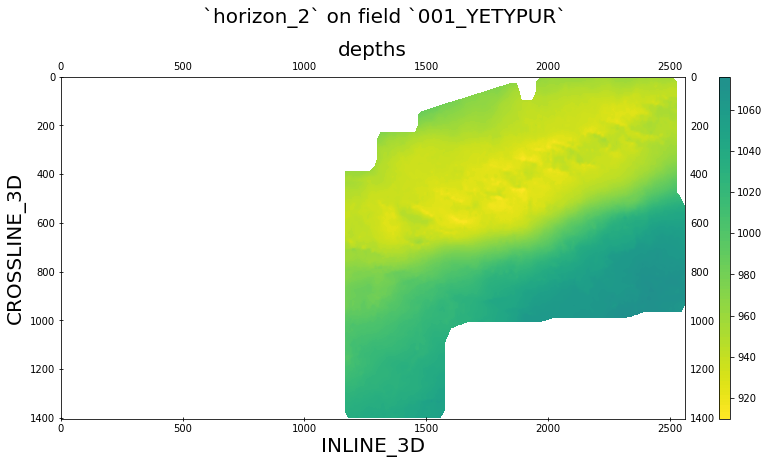

In [10]:
horizon_1 = Horizon(horizon.points[:1_400_000, :],
                    field=field, name='horizon_1')

horizon_2 = Horizon(horizon.points[1_000_000:, :],
                    field=field, name='horizon_2')

horizon_1.show(xlim=(0, horizon.shape[0]), ylim=(horizon.shape[1], 0), figsize=FIGSIZE)
horizon_2.show(xlim=(0, horizon.shape[0]), ylim=(horizon.shape[1], 0), figsize=FIGSIZE)

The `check_proximity` method returns a dictionary with stats on how close the horizons are, both spatial and heights wise. The `spatial_position` field in the result tells us positions of horizons relative to each other:

In [11]:
Horizon.check_proximity(horizon_1, horizon_2)

{'mean': 0.0,
 'diffs': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'spatial_position': 'overlap',
 'abs_mean': 0.0,
 'max': 0,
 'abs_max': 0,
 'std': 0.0,
 'abs_std': 0.0,
 'window_rate': 1.0,
 'offset_diffs': array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}

Horizons are overlapped, so we use the `overlap_merge` method.

Merged successfully: True


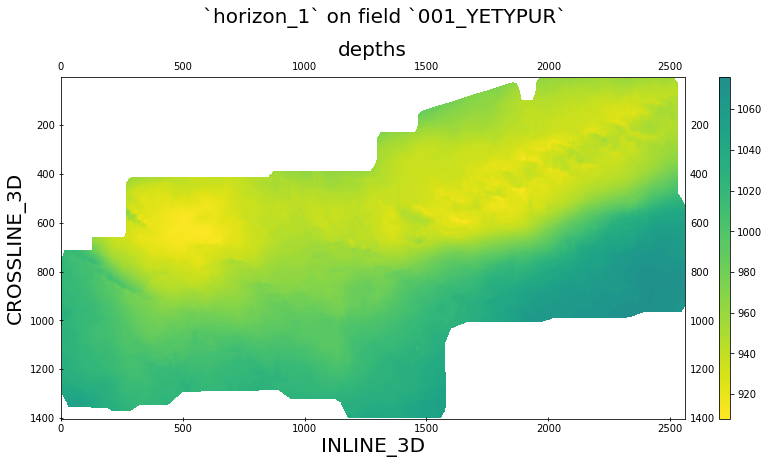

CPU times: user 630 ms, sys: 298 ms, total: 929 ms
Wall time: 579 ms


In [12]:
%%time
merged_horizon = Horizon.overlap_merge(horizon_1, horizon_2)

print('Merged successfully:', np.all(horizon.matrix==merged_horizon.matrix))
merged_horizon.show(figsize=FIGSIZE)

So, from now you know how to make an entire horizon from its parts when you work with vast amounts of data.

<a id='add_manipulations'></a>
# Additional manipulations

For some cases, we need **specific horizons processing**. In this chapter, we will show you some manipulations which are helpful in seismic interpretation tasks.

For example, we use a **horizon carcass** in the horizon detection task: we take data slices from a carcass to train a model to predict a horizon to the whole spatial range.

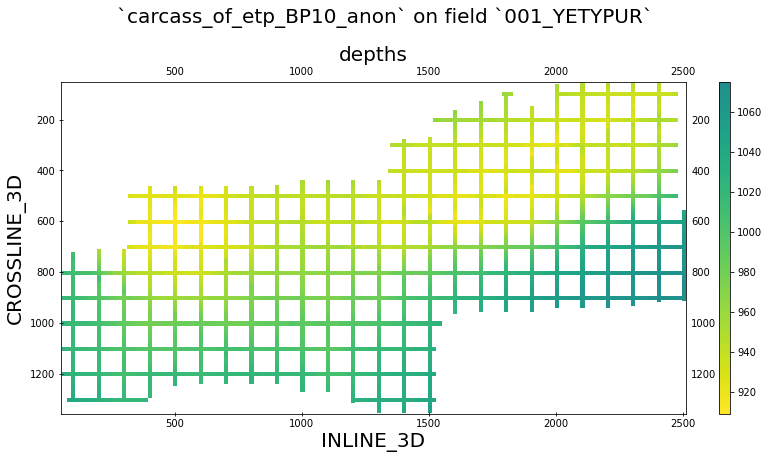

CPU times: user 48.2 s, sys: 516 ms, total: 48.8 s
Wall time: 5.01 s


In [13]:
%%time
carcass = horizon.make_carcass(frequencies=100, regular=True, apply_smoothing=True)
carcass.show(figsize=FIGSIZE, load_kwargs={'enlarge': True})

To expand the validation dataset for the horizon extension task, we create **horizons with holes** and train models to trace each horizon in gaps.

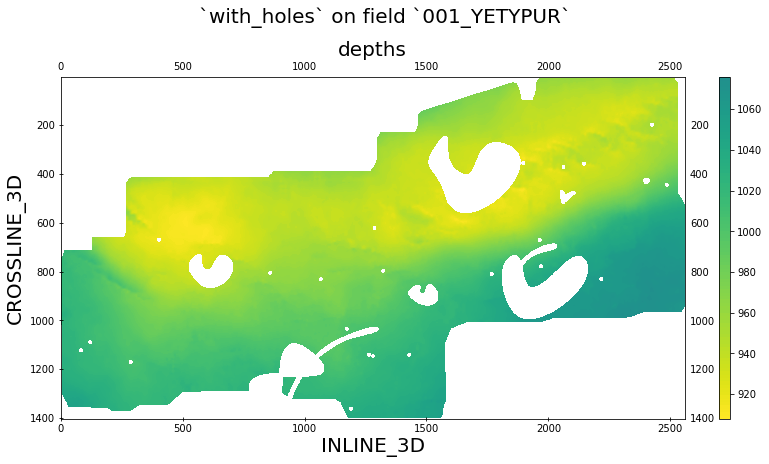

CPU times: user 2.31 s, sys: 361 ms, total: 2.67 s
Wall time: 2.28 s


In [14]:
%%time
holes_matrix = horizon.make_random_holes_matrix(seed=13)
horizon_with_holes = Horizon(horizon.full_matrix, field=horizon.field, name='with_holes')
horizon_with_holes.filter(holes_matrix)

horizon_with_holes.show(figsize=FIGSIZE)

Sometimes model predictions contain **unwanted effects**, which we eliminate using the `despike` method. This helps to make better predictions in these areas.

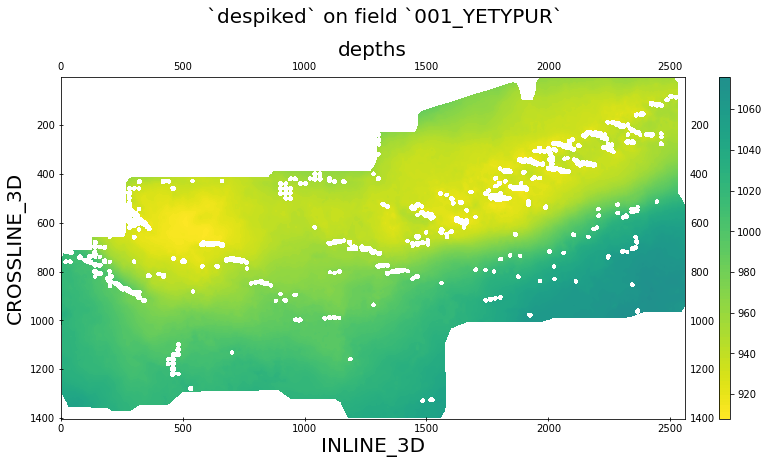

CPU times: user 1.45 s, sys: 322 ms, total: 1.77 s
Wall time: 1.36 s


In [15]:
%%time
horizon_despiked = Horizon(horizon.full_matrix, field=horizon.field, name='despiked')
horizon_despiked.despike()
horizon_despiked.show(figsize=FIGSIZE)

# Conclusion

This concludes the `Horizon` tutorial. To sum up, you have learned:

- ways to get insights from surfaces in seismic data
- how merging horizons is working
- cache manipulations
- some specific manipulations with horizons

In [the next one](./03_Cubeset.ipynb), you will learn how to work with an entire dataset of seismic cubes and horizons!